# CALVIN EDA
This document's objectives are
- Check the offline dataset have sensor data (not vision)
- How to build dataloader and configure files

### Import Libs

In [8]:
import os
import pickle
import gzip
from glob import glob

import h5py
import numpy as np
from tqdm import tqdm

from matplotlib import pyplot as plt

import yaml


In [9]:
npz  = np.load("LVD/contrib/calvin/dataset/task_D_D/training/episode_0351566.npz")

# actions, rel_actions, robot_obs, scene_obs

# calvin.get_dataset 해서 가져올 수 있게끔. 
obs = { k : npz[k] for k in  ['robot_obs', 'scene_obs', 'actions', 'rel_actions']}

obs['robot_obs'].shape, obs['scene_obs'].shape

# robot obs

# EE Pos
# EE orientation
# Gripper width
# Joint Positions
# Gripper actions

# EE 는 End Effector같음.
# 일단 다 넣어서 해보고, 잘되면 빼서하자. 다른애들 못하게
# action은 joint action만 넣고 

((15,), (24,))

# CALVIN envs Offline dataset
- offline dataset의 조건은 오브젝트들을 떨어뜨리지 말고 놀아볼 것
- 이걸 나중에 labeling해서 얻어낸 dataset임
- skill이 diverse한 상황이라 내 방법론의 강점을 보여주기엔 좋아보임.

## States
## Robot 
- 7 DoF Franka Robot with gripper
- sliding door, drawer가 있는 책상
- 초록불을 켜는 버튼
- 전구 켜는 스위치
- 색상 / 모양이 각각 다른 직육면체 블록
- 모든 환경은 다른 texture를 갖고
- 책상, 로봇, 카메라 빼곤 다 다름.


## Robot Observations
Total 15 robot obs and 24 scene obs (observation for objects).
- EE Pos 3
- EE Orientation 3
- Gripper Width 1
- Joint Pos 7
- Gripper action 1

아마 쓰면 Joint Pos, Gripper Width, Gripper action 정도 쓸듯

## Scene Observation
- 0 : slider position 음수면 오른쪽
- 1 : 서랍. 음수면 넣음
- 2 : 검은 버튼 위치. 양수면 눌림
- 3 : 전구 켜는 레버
- 4 : 전구 상태. discrete. 0 or 1
- 5 : 버튼누르면 켜지는 초록 불.  discrete. 0 or 1
- 6, 7, 8, 9, 10, 11 : red cube xyz, rad xyz
- 12, 13, 14, 15, 16, 17 : red cube xyz, rad xyz
- 18, 19, 20, 21, 22, 23 : red cube xyz, rad xyz

## Task
Scene obs를 적당히 조작 후 PlayTableEnv에 내장된 state 체크함수를 통해서 reward를 줌.
task는 크게 2가지
- microwave 처럼 고정된 위치의 object 조작. 
- kettle 처럼 들고 움직일 수 있는 object 조작. kitchen에 비해 대폭 늘어남. 
난이도는 kitchen에 비해 괜찮을 것으로 추정. skill이 diverse하긴 하지만, object간의 transition이 dense하고 무엇보다 거리가 가까움.

## Task 구성
- Skimo: Slider / Drawer / Light / Button 딱 1개만 수행함. task가 1개라 너무 적고 쉬움.
- LVD : 반드시 goal state를 세팅해줘야 하고, 미리보기가 효과가 있어야 함. 따라서 offline dataset과 reset 상황이 크게 다르지 않은 경우에 한정해서 task를 짜야 함

### 고정위치의 Task
- Slider / Drawer / Light / Button
- 각 task별로 on / off가 있음. 


### 가변위치의 task
- block과 관련된 task. reset 할 때 마다 위치가 달라진다. 어디있는지 
- push / lift / place 
    - push는 단독 사용 가능 
    - lift / place는 합쳐서 해야 함.

### task 구성
- 고정위치 task를 순서 섞고
- 파란 블록 task를 추가
그러면
- 고정위치 4개
- push blue + 고정위치 3개
- 고정위치 1개 + slider or drawer + lift + place 





In [91]:
from LVD.contrib.calvin.calvin_env.calvin_env.envs.play_table_env import PlayTableSimEnv

In [92]:
from hydra import initialize, compose
import hydra


with initialize(config_path="./LVD/contrib/calvin/calvin_env/conf/"):
    cfg = compose(config_name="config_data_collection.yaml", overrides=["cameras=static_and_gripper"])
    cfg.env["use_egl"] = False
    cfg.env["show_gui"] = False
    cfg.env["use_vr"] = False
    cfg.env["use_scene_info"] = True
    print(cfg.env)

env = hydra.utils.instantiate(cfg.env)


{'_target_': 'calvin_env.envs.play_table_env.PlayTableSimEnv', '_recursive_': False, 'cameras': '${cameras}', 'seed': 0, 'bullet_time_step': 240.0, 'use_vr': False, 'show_gui': False, 'robot_cfg': '${robot}', 'scene_cfg': '${scene}', 'use_scene_info': True, 'use_egl': False, 'control_freq': 30}


In [94]:
for k in npz.keys():
    print(k)

actions
rel_actions
robot_obs
scene_obs
rgb_static
rgb_gripper
rgb_tactile
depth_static
depth_gripper
depth_tactile


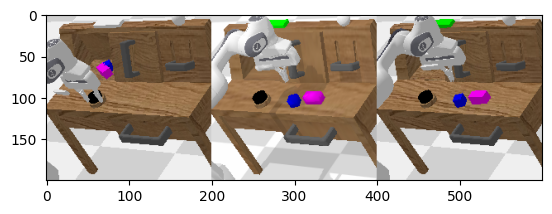

In [95]:
env.robot.reset()
reset = env.render(mode = "rgb_array")
env.robot.reset(robot_state = npz['robot_obs'])
env.scene.reset(scene_obs= npz['scene_obs'])

rendered = env.render(mode = "rgb_array")

saved = npz['rgb_static']

img = np.concatenate((reset, saved ,rendered), axis = 1)

plt.imshow(img)
plt.show()
# good

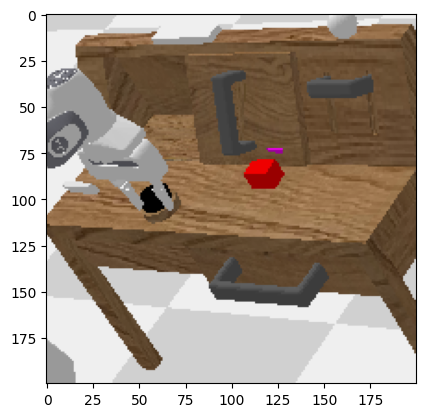

In [109]:
init_scene = env.reset()['scene_obs']
init_scene[0] = 0.2
init_scene[1] = 0.2


# fig, ax = plt.subplots(2, 4, figsize = (20, 10))
# for i in range(8):
#     x, y = divmod(i, 4)
#     obs = env.reset()
#     scene_obs = obs['scene_obs']
#     scene_obs[3] = 0.1
#     # scene_obs[:2] = [0.5, 0.2]
#     # scene_obs[14] = 0.6
#     env.scene.reset(scene_obs)
#     reset = env.render(mode = "rgb_array")
#     ax[x][y].imshow(reset)


obs = env.reset()

scene_obs = obs['scene_obs']
scene_obs[3] = 0.08
# scene_obs[:2] = [0.5, 0.2]
# scene_obs[14] = 0.6

env.scene.reset(scene_obs)
reset = env.render(mode = "rgb_array")

plt.imshow(reset)

plt.show()
# good

# Env

In [1]:
from LVD.envs import ENV_TASK
from LVD.utils import *

env_cls, task_cls, tasks, cfg = ENV_TASK['calvin'].values()

env = env_cls(**cfg)
task_obj = task_cls(tasks[0])

with env.set_task(task_obj):
    init_state = env.reset()

    goal_state = np.zeros(6)

    for subtask in env.TASK_ELEMENTS:
        goal_state[CALVIN_EL_INDICES[subtask]] = CALVIN_EL_GOALS[subtask]
    
GOAL_CHECKERS['calvin'](init_state)

No module named 'flow'
/home/magenta1223/anaconda3/envs/skill/lib/python3.7/site-packages/glfw/__init__.py:912: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: May 20 2022 19:43:01
/home/magenta1223/anaconda3/envs/skill/lib/python3.7/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config_data_collection.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/home/magenta1223/anaconda3/envs/skill/lib/python3.7/site-packages/hydra/core/default_element.py:126: UserWarning: In 'vr_input/vr_controller/vive': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/changes_to_package_header for more information
  See {url} for more information"""
/home/magenta1223/anaconda3/envs/skill/lib/python3

argv[0]=
WARNING uncommitted modified files: calvin_env/envs/play_table_env.py


[]

In [2]:
init_state[-6:], goal_state

(array([0.15, 0.12, 0.  , 0.08, 1.  , 1.  ]),
 array([0.15, 0.12, 0.  , 0.08, 1.  , 1.  ]))

In [4]:
GOAL_CHECKERS['calvin'](GOAL_TRANSFORM['calvin'](init_state))

# GOAL_TRANSFORM['calvin'](init_state)

['move_slider_left', 'open_drawer', 'turn_on_light_bulb', 'turn_on_led']

In [156]:
# 고정 task
# open drawer, slider left, turn_on_led, turn_on_light_bulb

fixed_position_task = ['open_drawer', 'move_slider_left', 'turn_on_led', 'turn_on_light_bulb']
d_or_s = ['open_drawer', 'move_slider_left']

push_task = ['push_blue_block_left', 'push_blue_block_right']
lift_place_task = [ 'lift_blue_block_table', 'lift_blue_block_slider', 'lift_blue_block_drawer', 'place_in_slider', 'place_in_drawer']

## Task Composition

### Shuffle Fixed Position task

In [157]:
import random 

random.shuffle(fixed_position_task)
fixed_position_task

['turn_on_light_bulb', 'turn_on_led', 'move_slider_left', 'open_drawer']

### Push task + 3 fixed

In [158]:
random.sample(push_task, 1) + random.sample(fixed_position_task, 3)

['push_blue_block_left',
 'turn_on_light_bulb',
 'turn_on_led',
 'move_slider_left']

### Complex Task

- slider or drawer 
- lift
- place 
- 1 fixed

In [159]:
lift_place_task


dors = random.sample(d_or_s, 1)[0]
copied = deepcopy(fixed_position_task)
copied.remove(dors)
fixed = random.sample(copied, 1)[0]

if "drawer" in dors:
    lift = "lift_blue_block_drawer"
    place = "place_in_drawer"
else:
    lift = "lift_blue_block_slider"
    place = "place_in_slider"


task = [dors, fixed, lift, place]

task

['open_drawer',
 'move_slider_left',
 'lift_blue_block_drawer',
 'place_in_drawer']

# Preprocess Offline dataset

In [160]:
npz  = np.load("/home/magenta1223/skill-based/SiMPL/proposed/contrib/calvin/dataset/task_D_D/training/episode_0351566.npz")

# actions, rel_actions, robot_obs, scene_obs

# calvin.get_dataset 해서 가져올 수 있게끔. 
obs = { k : npz[k] for k in  ['robot_obs', 'scene_obs', 'actions', 'rel_actions']}

In [177]:

prefix = "/home/magenta1223/skill-based/SiMPL/proposed/contrib/calvin/dataset/task_D_D/training/"

all_files = sorted(glob(f"{prefix}/*.npz"))
seq_indices = np.load(f"{prefix}/ep_start_end_ids.npy")
seq_indices = np.sort(seq_indices, axis = 0)

In [197]:
seq_indices.shape[0]

31

In [200]:
import cv2

start, end = seq_indices[0]

imgs = []

for f in range(start, end+1, 2):
    npz  = np.load(f"{prefix}/episode_{str(f).zfill(7)}.npz")
    # calvin.get_dataset 해서 가져올 수 있게끔. 
    obs = { k : npz[k] for k in  ['robot_obs', 'scene_obs', 'actions', 'rel_actions']}
    env.robot.reset(robot_state = npz['robot_obs'])
    env.scene.reset(scene_obs= npz['scene_obs'])
    # img = env.render(mode = "rgb_array")
    img = npz['rgb_static']
    imgs.append(img)


mp4_path = f"./imgs/video.mp4"
out = cv2.VideoWriter(mp4_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 30, (200,200))

for i in range(len(imgs)):
    # writing to a image array
    out.write(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
out.release() 

In [198]:
imgs[0].shape

(200, 200, 3)

In [194]:
for k in npz.keys():
    print(k)

actions
rel_actions
robot_obs
scene_obs
rgb_static
rgb_gripper
rgb_tactile
depth_static
depth_gripper
depth_tactile


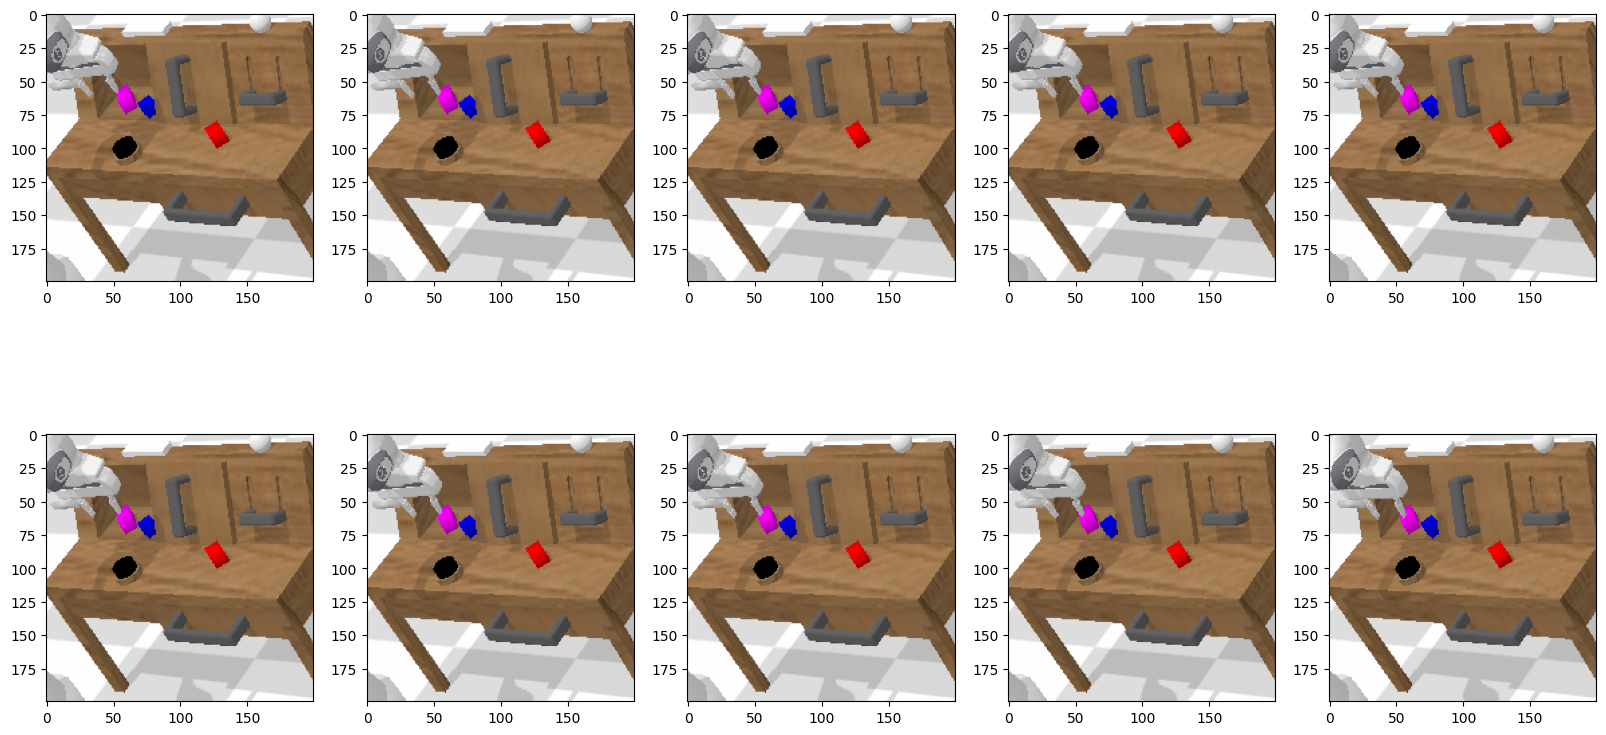

In [201]:
fig, ax = plt.subplots(2, 5, figsize = (20, 10))

for i in range(10):
    x, y = divmod(i, 5)
    ax[x][y].imshow(imgs[i])

plt.show()

어.. 일단 뭐 한다 쳐도 skimo에서는 대충 1.3K 개의 dataset을 썼다고 하는데 나는 아무리봐도 31개거든 ? 그냥 믿고 쓰자 ㅋㅋ

In [15]:
from LVD.data.calvin.calvin_data_loader import *
from LVD.configs.env import *
from LVD.utils import *
from LVD.envs import *
from matplotlib import pyplot as plt


env_cls = ENV_TASK["calvin"]['env_cls']
task_cls = ENV_TASK["calvin"]['task_cls']
ALL_TASKS = ENV_TASK["calvin"]['tasks']
configure = ENV_TASK["calvin"]['cfg']

if configure is not None:
    env = env_cls(**configure)
else:
    env = env_cls()


env_config = CALVINEnvConfig()


data_dir = "."
data_conf = edict(
    dataset_spec = env_config.attrs,
    subseq_len = 10 + 1, # conf.model.n_rollout_steps + 1
    device = "cpu"
)
phase = "train"

dataset =CALVIN_Dataset(data_dir, data_conf, phase)

argv[0]=
WARNING uncommitted modified files: calvin_env/envs/play_table_env.py


In [2]:
# imgs_state = []
state_processor = StateProcessor(env_name= "calvin")


imgs_dict = {}

for seq in dataset.seqs:
    prev_goal = None
    for ob in seq['obs']:
        env.set_state(robot_state= ob[:15], scene_state= ob[15:])
        # imgs_state.append(env.render(mode = "rgb_array"))
        # goal = GOAL_CHECKERS['calvin'](ob[15:21])
        goal = state_processor.state_goal_checker(ob[:21], mode = "state")

        subtasks = goal.split("_")
        if prev_goal != goal:
            imgs_dict[f"{prev_goal}->{goal}"] = env.render(mode = "rgb_array")
            prev_goal = goal        


        # 어떤 subtask가 생겼다가 사라진 구간이 있는지 확인해야 함.
        # 
        # print(goal)
        # if prev_goal != goal:
        #     print(goal)
        #     prev_goal = goal
    # 역방향인 경우가 얼마나 있지? 
    break



# mp4_path = "test.mp4"
# out = cv2.VideoWriter(mp4_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 20, (200,200))

# for i in range(len(imgs_state)-1):
#     # writing to a image array
#     img_s = imgs_state[i].astype(np.uint8)
#     out.write(cv2.cvtColor(img_s, cv2.COLOR_BGR2RGB))
# out.release() 


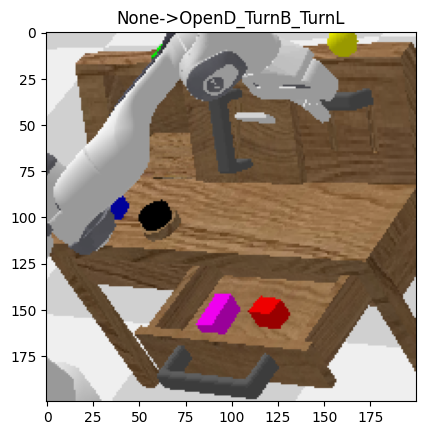

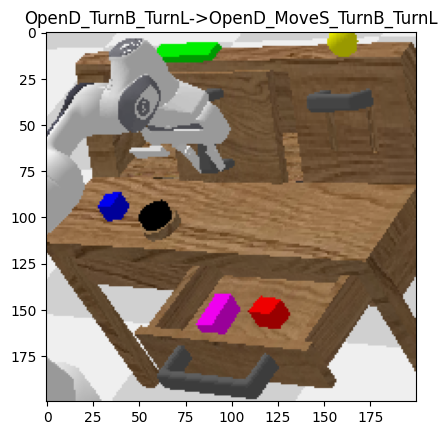

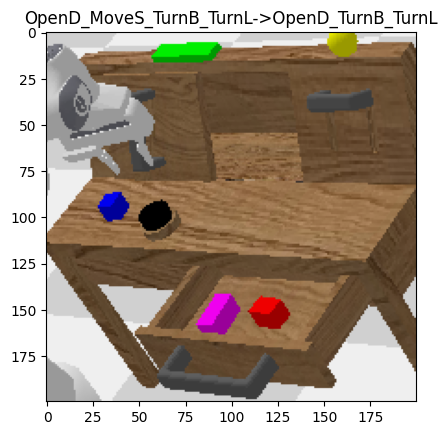

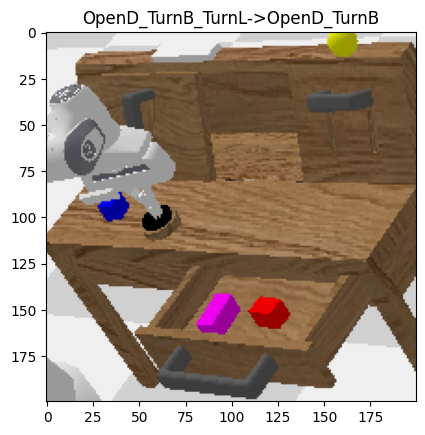

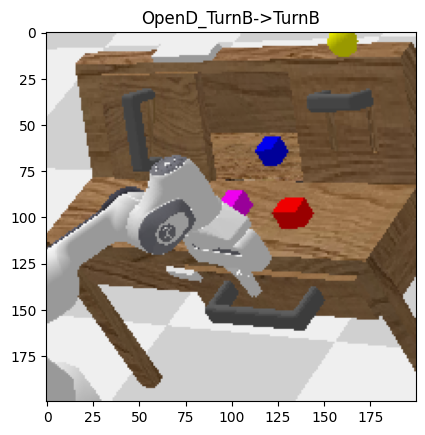

In [3]:
for k, v in imgs_dict.items():
    plt.imshow(v)
    plt.title(k)
    plt.show()

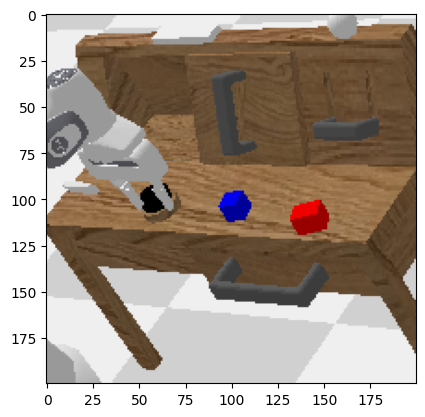

open_drawer
GET REWARD !! open_drawer
turn_on_lightbulb
GET REWARD !! turn_on_lightbulb
move_slider_left


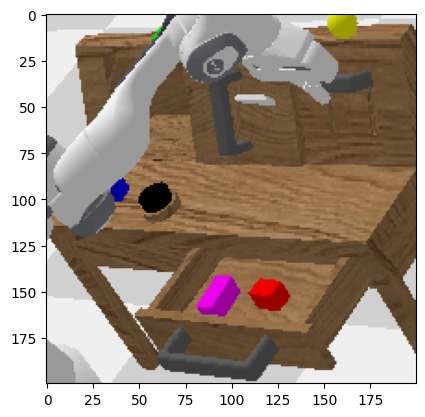

In [8]:
task = CALVIN_Task(ALL_TASKS[0])

with env.set_task(task):
    state = env.reset()
    goal = state_processor.state_goal_checker(state, mode = "goal")

start_info = deepcopy(env.start_info)

plt.imshow(env.render(mode = "rgb_array"))
plt.show()

do_break= False
for seq in dataset.seqs:
    prev_goal = None
    for ob in seq['obs']:

        with env.set_task(task):
            env.reset()

            env.set_state(robot_state= ob[:15], scene_state= ob[15:])
            goal = state_processor.state_goal_checker(ob[:21], mode = "state")
            if "OpenD_TurnB" in goal:
                reward, done = env._success()
                do_break = True
                break
                print(goal)
    
        
    if do_break:
        break
            # print(goal)
    # print(env._success())

plt.imshow(env.render(mode = "rgb_array"))
plt.show()


In [24]:
import seaborn as sns

for i in range(7):
    print(np.std(actions[:, i]))

0.27367842
0.2330512
0.22002327
0.15466619
0.16892675
0.26518035
0.99102086


In [25]:
seq = dataset.seqs[0]

In [30]:
states = seq['obs']
actions = seq['actions']

In [74]:
from LVD.env_vis import *



def render_calvin(env, states, actions, mode):
    """
    rollout을 통해 만들어낸 trajectory의
    -state sequence를 강제로 세팅
    -초기 state를 세팅하고, actino을 환경상에서 수행
    두 개를 비교
    """
    Hsteps = 10
    imgs = []
    video_len = states.shape[0]

    if mode == "state":
        for i in range(video_len):
            imgs.append(render_state(env, "calvin", states[i]))

    else:
        imgs.append(render_state(env, "calvin", states[0]))


        # for i in range(Hsteps - 1):
        for i in range(video_len-1):

            # render 
            # img = render_action(env, "calvin", actions[i].detach().cpu().numpy())
            img = render_action(env, "calvin", actions[i])

            imgs.append(img)

    
        # for i in range(Hsteps + 1, video_len):
        # # for i in range(self.Hsteps + 1):
        #     imgs.append(img)

    return imgs


env = CALVIN_GC_PlayTableSim_Env(**cfg_env)
# state를 강제로 setting했을 때
env.reset()

states_render = states[100:200]
actions_render = actions[100:199]

imgs_state = render_calvin(env, states_render, actions_render, mode = "state")
# action을 수행했을 때 
env.reset()
imgs_action = render_calvin(env, states_render, actions_render, mode = "action")

argv[0]=
WARNING uncommitted modified files: calvin_env/envs/play_table_env.py
disconnecting id 2 from server


In [75]:
mp4_path = "test.mp4"
out = cv2.VideoWriter(mp4_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 20, (600,200))

for i in range(len(imgs_state)-1):
    # writing to a image array
    img_s = imgs_state[i].astype(np.uint8)
    img_a = imgs_action[i].astype(np.uint8)
    img = np.concatenate((img_s,img_a, np.abs(img_s - img_a)), axis = 1)
    out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
out.release() 

In [70]:
img_s.shape

(200, 200, 3)

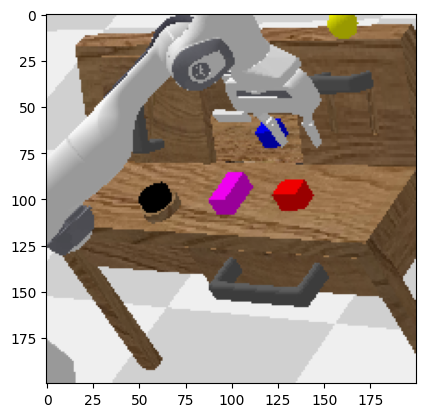

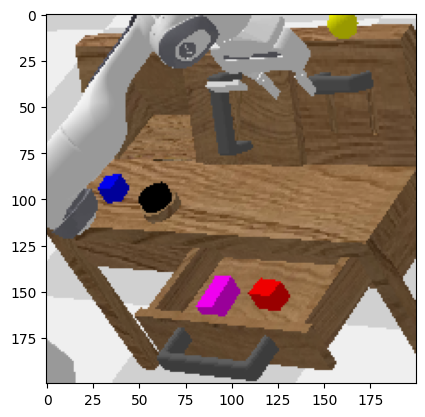

In [43]:
plt.imshow(img_s)
plt.show()
plt.imshow(img_a)
plt.show()


In [13]:
dataset.seqs[0]['actions']

(500, 7)

In [24]:
# imgs_state = []
state_processor = StateProcessor(env_name= "calvin")




for seq in dataset.seqs:
    prev_goal = None
    ob = seq['obs'][0]
    

    task = CALVIN_Task(ALL_TASKS[0])

    with env.set_task(task):
        env.reset()
        env.set_state(robot_state= ob[:15], scene_state= ob[15:])
        imgs = []
        for action in seq['actions']:
            ob, _, _, _ = env.step(action)
            # imgs_state.append(env.render(mode = "rgb_array"))
            # goal = GOAL_CHECKERS['calvin'](ob[15:21])
            goal = state_processor.state_goal_checker(ob[:21], mode = "state")

            img = env.render(mode = "rgb_array")
            
            img = img.astype(np.int8)

            cv2.putText(img, goal, color = (255,0,0),  org = (200 // 2, 200 // 2), fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale= 2, lineType= cv2.LINE_AA)

            imgs.append(img)


    break



mp4_path = "test_action.mp4"
out = cv2.VideoWriter(mp4_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 20, (200,200))

for i in range(len(imgs)-1):
    # writing to a image array
    img = imgs[i].astype(np.uint8)
    out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
out.release() 

open_drawer
GET REWARD !! open_drawer
turn_on_lightbulb
GET REWARD !! turn_on_lightbulb
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider_left
move_slider

In [1]:
import torch
import torch.nn as nn

In [6]:
m = nn.LSTM(8, 16, batch_first = True)

In [7]:
x = torch.randn(7, 23, 8)


output, (h, c) = m(x)

In [10]:
output.shape, h.shape

(torch.Size([7, 23, 16]), torch.Size([1, 7, 16]))

In [12]:
from torch.nn import functional as F

nn.Sequential(
    nn.Linear(8, 16),
    F.relu()
)

TypeError: relu() missing 1 required positional argument: 'input'

In [3]:
import numpy as np

np.random.rand(2) * 100

array([27.5831863 , 30.55562311])

In [14]:
pos = np.array(list(range(20)), dtype= np.float32).reshape(5,-1)
pos

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.],
       [12., 13., 14., 15.],
       [16., 17., 18., 19.]], dtype=float32)

In [15]:
pos[:, :2] += 0.33
pos

array([[ 0.33,  1.33,  2.  ,  3.  ],
       [ 4.33,  5.33,  6.  ,  7.  ],
       [ 8.33,  9.33, 10.  , 11.  ],
       [12.33, 13.33, 14.  , 15.  ],
       [16.33, 17.33, 18.  , 19.  ]], dtype=float32)

In [17]:
import pickle


with open("/home/magenta1223/skill-based/SiMPL/proposed/LVD/maze_states_skild.pkl", mode = "rb") as f:
    dataset = pickle.load(f)

In [24]:
dataset[0]['obs'].shape

(501, 4)

In [23]:
len(dataset)

3046